In [179]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn import linear_model
import plotly.express as px
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

In [129]:
data = pd.read_csv('train-2.csv', header=0)

In [130]:
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [132]:
data.shape

(1460, 81)

In [133]:
data = data.drop("Id", axis=1)

Я убрала столбец Id, поскольку для обучения модели он не нужен и потребуется потом, чтобы для каждого Id предсказать стоимость

In [134]:
data_nan = data.isna().sum()
columns_with_nan = data_nan[data_nan > 0]
print(columns_with_nan)

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


Также удалю столбец Alley, в нем 1369 пропущенных значений, в то время как всего сток 1460, это гораздо больше половины. К тому же Alley = Type of alley access, гораздо больше на стоимость влияет расстояние до Alley.
Тоже самое с PoolQC, он не говорит о наличии бассейна, а только о его качестве, гораздо важнее знать есть ли он. К тому же 1453 пропущенных значений из 1460 это почти все пропущенные значения.
И также 1406 пропущенных в MiscFeature, его тоже удалю.

In [135]:
data = data.drop("Alley", axis=1)
data = data.drop("PoolQC", axis=1)
data = data.drop("MiscFeature", axis = 1)

Про NaN:
1) LotFrontage = Linear feet of street connected to property, расстояние до улицы может влиять на стоимость, как, например, расстояние до станции метро влияет, так что заполнять нулями или большим числом приведет к неправильным выводам, поэтому буду заполнять средним значением по столбцу 
2) MasVnrType = Masonry veneer type, заполню самым частым встречающимся
3) MasVnrArea = Masonry veneer area in square feet, заполню средним значением
4) BsmtQual = Height of the basement
5) BsmtCond = General condition of the basement, заполню самым частым встречающимся
6) BsmtExposure = Walkout or garden level basement walls - удалю, как и все остальное про подвал: BsmtFinType1 = Quality of basement finished area, BsmtFinType2: Quality of second finished area (if present)
9) Electrical = Electrical system, заполню самым частым встречающимся
10) FireplaceQu = Fireplace quality самым частым
11) GarageType = Garage location самым частым встречающимся
12) GarageYrBlt - средним
13) GarageFinish - самым частым встречающимся
14) GarageQual - самым частым встречающимся
15) GarageCond - самым частым встречающимся
16) Fence - самым частым встречающимся

In [136]:
data = data.drop(["BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF"], axis = 1)

In [137]:
if data["LotFrontage"].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(data["LotFrontage"]):
                fill_value = data["LotFrontage"].mean()
            data["LotFrontage"].fillna(fill_value, inplace=True)
if data["MasVnrArea"].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(data["MasVnrArea"]):
                fill_value = data["MasVnrArea"].mean()
            data["MasVnrArea"].fillna(fill_value, inplace=True)
if data["GarageYrBlt"].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(data["GarageYrBlt"]):
                fill_value = data["GarageYrBlt"].mean()
            data["GarageYrBlt"].fillna(fill_value, inplace=True)
            

if pd.api.types.is_object_dtype(data['MasVnrType']):
            fill_value2 = data['MasVnrType'].mode()[0]
            data['MasVnrType'].fillna(fill_value2, inplace=True)
if pd.api.types.is_object_dtype(data['BsmtCond']):
            fill_value2 = data['BsmtCond'].mode()[0]
            data['BsmtCond'].fillna(fill_value2, inplace=True)
if pd.api.types.is_object_dtype(data['BsmtQual']):
            fill_value2 = data['BsmtQual'].mode()[0]
            data['BsmtQual'].fillna(fill_value2, inplace=True)
if pd.api.types.is_object_dtype(data['Electrical']):
            fill_value2 = data['Electrical'].mode()[0]
            data['Electrical'].fillna(fill_value2, inplace=True)
if pd.api.types.is_object_dtype(data['GarageType']):
            fill_value2 = data['GarageType'].mode()[0]
            data['GarageType'].fillna(fill_value2, inplace=True)
if pd.api.types.is_object_dtype(data['GarageFinish']):
            fill_value2 = data['GarageFinish'].mode()[0]
            data['GarageFinish'].fillna(fill_value2, inplace=True)
if pd.api.types.is_object_dtype(data['GarageQual']):
            fill_value2 = data['GarageQual'].mode()[0]
            data['GarageQual'].fillna(fill_value2, inplace=True)
if pd.api.types.is_object_dtype(data['GarageCond']):
            fill_value2 = data['GarageCond'].mode()[0]
            data['GarageCond'].fillna(fill_value2, inplace=True)
if pd.api.types.is_object_dtype(data['Fence']):
            fill_value2 = data['Fence'].mode()[0]
            data['Fence'].fillna(fill_value2, inplace=True)
if pd.api.types.is_object_dtype(data['FireplaceQu']):
            fill_value2 = data['FireplaceQu'].mode()[0]
            data['FireplaceQu'].fillna(fill_value2, inplace=True)

In [138]:
data.isnull().any().any()

False

Проверка показала, что NaN больше нет

Обработаю Категориальные признаки: Буду кодировать one-hot encoding только бинарные признаки. Всё остальное буду кодировать с помощью label encoding.

In [139]:
cat_names = data.select_dtypes('object').columns
float_names = data.select_dtypes('float64').columns
data_coded = data.copy()
label_columns = []
ohe_columns = []
for column in cat_names:
    if (data_coded[column].nunique() == 2):
        label_columns.append(column)
    else:
        ohe_columns.append(column)

In [140]:
for column in label_columns:
    le = LabelEncoder()
    data_coded[column] = le.fit_transform(data["Neighborhood"])

In [141]:
data_coded = pd.get_dummies(data_coded, columns = ohe_columns, drop_first = True, dtype = int)

Поскольку мы обработали все категориальные признаки, то можно работать со всей data, не делая drop столбцов

In [142]:
data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,MnPrv,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,MnPrv,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,MnPrv,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,MnPrv,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,MnPrv,0,12,2008,WD,Normal,250000


In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 71 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [145]:
data_corr = data.drop(labels = cat_names, axis = 1)
data_corr.corr()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.357056,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022895,-0.238518,-0.251758,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.357056,1.000000,0.306795,0.234196,-0.052820,0.117598,0.082746,0.179283,0.363358,0.414266,...,0.077106,0.137454,0.009790,0.062335,0.037684,0.180868,0.001168,0.010158,0.006768,0.334901
LotArea,-0.139781,0.306795,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103960,0.260833,0.299475,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.234196,0.105806,1.000000,-0.091932,0.572323,0.550684,0.410238,0.537808,0.476224,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.052820,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.127788,-0.171098,-0.144203,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.117598,0.014228,0.572323,-0.375983,1.000000,0.592855,0.314745,0.391452,0.281986,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.082746,0.013788,0.550684,0.073741,0.592855,1.000000,0.179186,0.291066,0.240379,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022895,0.179283,0.103960,0.410238,-0.127788,0.314745,0.179186,1.000000,0.362452,0.342160,...,0.159349,0.124965,-0.109849,0.018795,0.061453,0.011723,-0.029815,-0.005940,-0.008184,0.475241
TotalBsmtSF,-0.238518,0.363358,0.260833,0.537808,-0.171098,0.391452,0.291066,0.362452,1.000000,0.819530,...,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,-0.018479,0.013196,-0.014969,0.613581
1stFlrSF,-0.251758,0.414266,0.299475,0.476224,-0.144203,0.281986,0.240379,0.342160,0.819530,1.000000,...,0.235459,0.211671,-0.065292,0.056104,0.088758,0.131525,-0.021096,0.031372,-0.013604,0.605852


<Axes: >

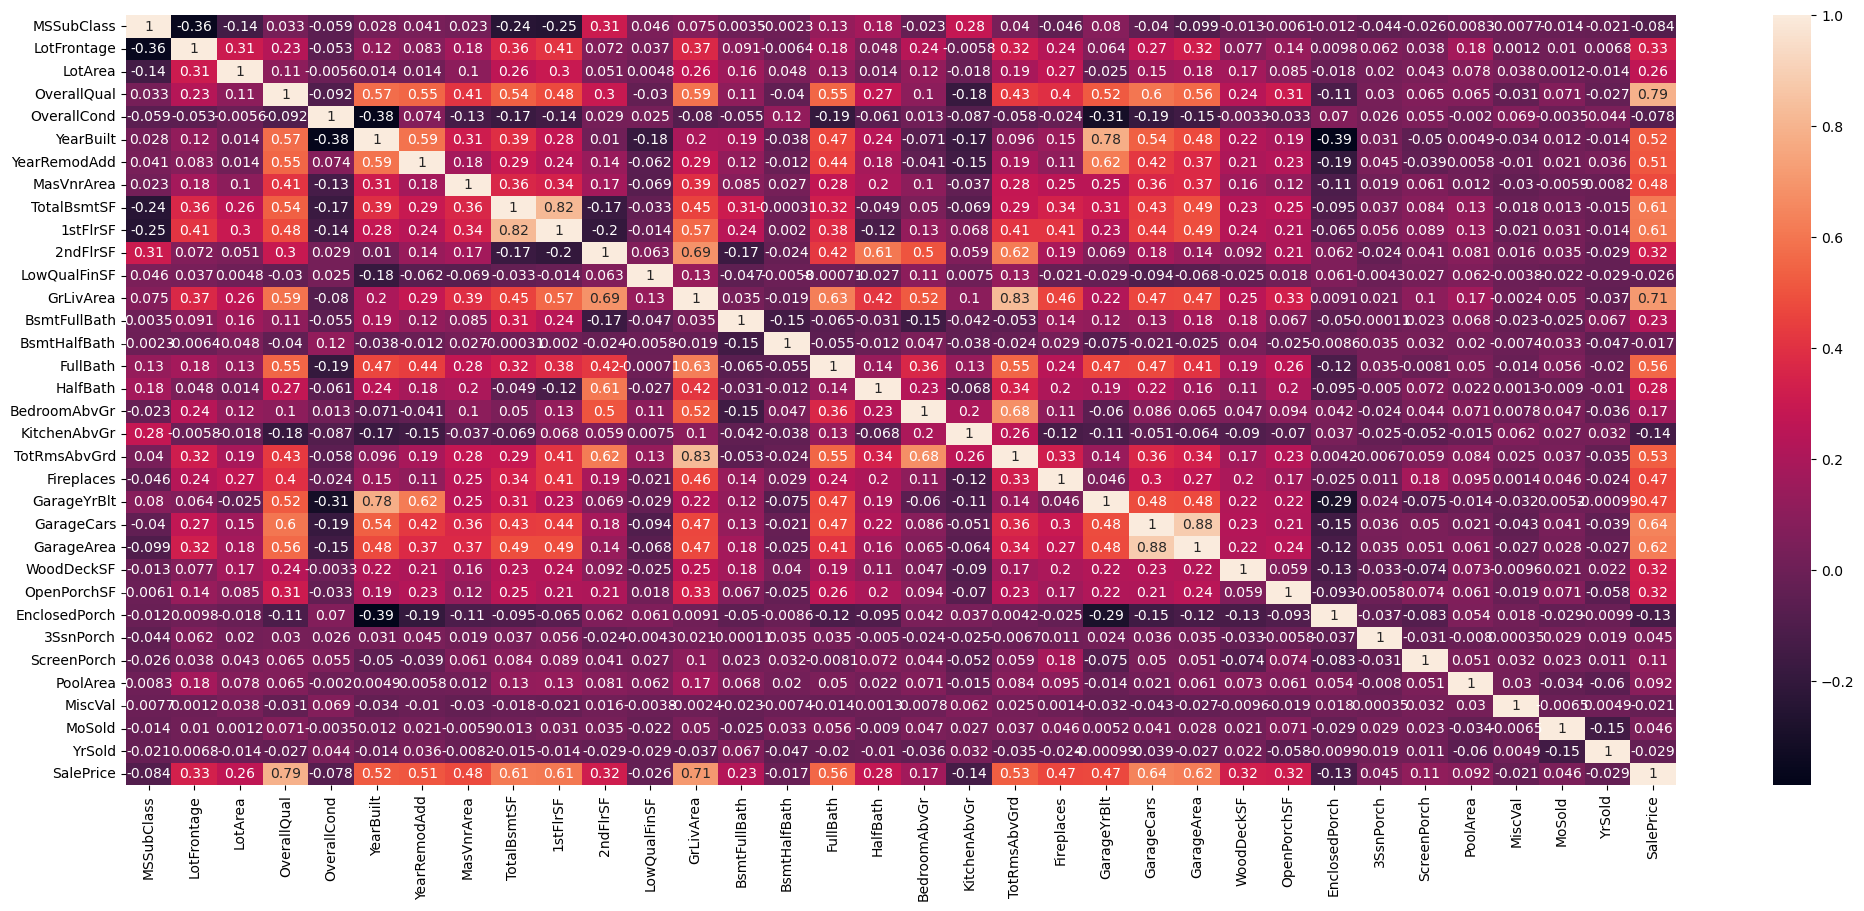

In [146]:
fig, ax = plt.subplots(figsize = (25, 10))
data_corr = data_corr.corr()
sns.heatmap(data_corr, linewidths = 0.001, annot = True)

Теперь корреляция с целевой переменной:

In [149]:
correlations = data_corr.abs()
target_corr = correlations['SalePrice'].drop('SalePrice')

max_corr_feature = target_corr.abs().idxmax()
min_corr_feature = target_corr.abs().idxmin()

max_corr_value = target_corr[max_corr_feature]
min_corr_value = target_corr[min_corr_feature]

print(f"Признак с максимальной корреляцией: ({max_corr_feature}, {max_corr_value})")
print(f"Признак с минимальной корреляцией: ({min_corr_feature}, {min_corr_value})")

Признак с максимальной корреляцией: (OverallQual, 0.7909816005838054)
Признак с минимальной корреляцией: (BsmtHalfBath, 0.016844154297358947)


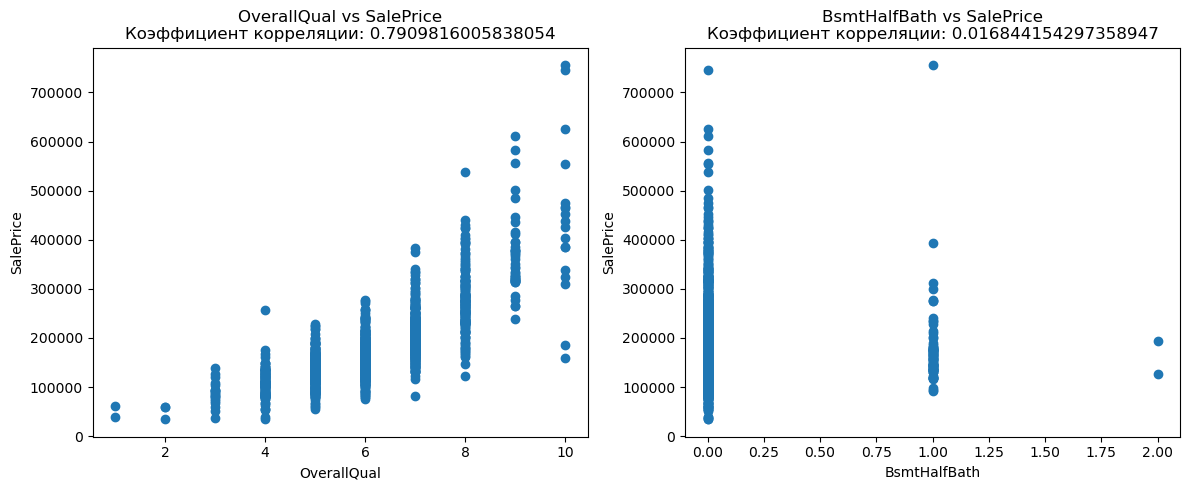

In [150]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[max_corr_feature], data['SalePrice'])
plt.xlabel(max_corr_feature)
plt.ylabel('SalePrice')
plt.title(f'{max_corr_feature} vs SalePrice\nКоэффициент корреляции: {max_corr_value}')

plt.subplot(1, 2, 2)
plt.scatter(data[min_corr_feature], data['SalePrice'])
plt.xlabel(min_corr_feature)
plt.ylabel('SalePrice')
plt.title(f'{min_corr_feature} vs SalePrice\nКоэффициент корреляции: {min_corr_value}')

plt.tight_layout()
plt.show()

Разобьем выборку на обучающую и тестовую в соотношении 75:25. Для избавления от разницы в масштабах буду логарифмировать переменную. 

In [151]:
np.random.seed(13)

In [152]:
X = data_coded.drop('SalePrice', axis = 1)
y = data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, np.log1p(y), test_size = 0.25)

Применим к данным Линейную регрессию, Lasso, Ridge. Для каждого из методов подберу параметры с помощью кросс-валидации. Обучу алгоритмы с лучшими гиперпараметрами на обучающей выборке и оценю качество по метрикам RMSE, MAE, R^2

Линейная регрессия:

In [153]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [157]:
print('lin_reg MSE train: ', mean_squared_error(math.e**(y_train)-1, math.e**(lin_reg.predict(X_train))-1))
print('lin_reg MSE test: ', mean_squared_error(math.e**(y_test)-1, math.e**(lin_reg.predict(X_test))-1))

lin_reg MSE train:  254054757.0802682
lin_reg MSE test:  16515884313.45381


In [158]:
print('lin_reg MAE train: ', mean_absolute_error(math.e**(y_train)-1, math.e**(lin_reg.predict(X_train))-1))
print('lin_reg MAE test: ', mean_absolute_error(math.e**(y_test)-1, math.e**(lin_reg.predict(X_test))-1))

lin_reg MAE train:  11070.342609495598
lin_reg MAE test:  25147.443192018072


In [159]:
print('lin_reg r2_score train: ',r2_score(math.e**(y_train)-1, math.e**(lin_reg.predict(X_train))-1))
print('lin_reg r2_score test: ', r2_score(math.e**(y_test)-1, math.e**(lin_reg.predict(X_test))-1))

lin_reg r2_score train:  0.9590016011633529
lin_reg r2_score test:  -1.4944037214501682


In [161]:
coef_lin_reg = pd.DataFrame(lin_reg.coef_, index = X.columns, columns = ['coef'])
coef_lin_reg.sort_values(by = ['coef'])

,coef
Exterior1st_BrkComm,-0.414072
SaleCondition_Partial,-0.306484
LandSlope_Sev,-0.202777
Functional_Maj2,-0.197153
Electrical_Mix,-0.174693
...,...
MSZoning_RM,0.332938
BsmtCond_Po,0.354248
MSZoning_RL,0.368411
MSZoning_FV,0.380318


Lasso

In [168]:
lasso = linear_model.Lasso(alpha = 0.01)
lasso.fit(X_train, y_train)

Lasso(alpha=0.01)

In [169]:
print('lasso MSE train: ', mean_squared_error(math.e**(y_train)-1, math.e**(lasso.predict(X_train))-1))
print('lasso MSE test: ', mean_squared_error(math.e**(y_test)-1, math.e**(lasso.predict(X_test))-1))

lasso MSE train:  550768698.133996
lasso MSE test:  31111276414.13259


In [170]:
print('lasso MAE train: ', mean_absolute_error(math.e**(y_train)-1, math.e**(lasso.predict(X_train))-1))
print('lasso MAE test: ', mean_absolute_error(math.e**(y_test)-1, math.e**(lasso.predict(X_test))-1))

lasso MAE train:  15945.471506814312
lasso MAE test:  29951.409415503163


In [171]:
print('lasso r2_score train: ',r2_score(math.e**(y_train)-1, math.e**(lasso.predict(X_train))-1))
print('lasso r2_score test: ', r2_score(math.e**(y_test)-1, math.e**(lasso.predict(X_test))-1))

lasso r2_score train:  0.9111190240547075
lasso r2_score test:  -3.698754374493955


In [172]:
coef_lasso = pd.DataFrame(lasso.coef_, index = X.columns, columns = ['coef'])
coef_lasso.sort_values(by = ['coef'])

,coef
YrSold,-0.002407
GarageYrBlt,-0.000599
MSSubClass,-0.000232
MiscVal,-0.000031
PoolArea,-0.000015
...,...
YearBuilt,0.003489
BsmtFullBath,0.013950
Fireplaces,0.018872
OverallCond,0.043112


In [173]:
ridge = linear_model.Ridge(alpha = 0.1)
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [174]:
print('ridge MSE train: ', mean_squared_error(math.e**(y_train)-1, math.e**(ridge.predict(X_train))-1))
print('ridge MSE test: ', mean_squared_error(math.e**(y_test)-1, math.e**(ridge.predict(X_test))-1))

ridge MSE train:  254921423.92255247
ridge MSE test:  16453390402.122374


In [175]:
print('ridge MAE train: ', mean_absolute_error(math.e**(y_train)-1, math.e**(ridge.predict(X_train))-1))
print('ridge MAE test: ', mean_absolute_error(math.e**(y_test)-1, math.e**(ridge.predict(X_test))-1))

ridge MAE train:  11136.554490405357
ridge MAE test:  25001.453693240714


In [176]:
print('ridge r2_score train: ',r2_score(math.e**(y_train)-1, math.e**(ridge.predict(X_train))-1))
print('ridge r2_score test: ', r2_score(math.e**(y_test)-1, math.e**(ridge.predict(X_test))-1))

ridge r2_score train:  0.9588617417359333
ridge r2_score test:  -1.4849652292668507


In [177]:
coef_ridge = pd.DataFrame(ridge.coef_, index = X.columns, columns = ['coef'])
coef_ridge.sort_values(by = ['coef'])

,coef
Exterior1st_BrkComm,-0.355166
SaleCondition_Partial,-0.236531
LandSlope_Sev,-0.191926
Functional_Maj2,-0.191647
Neighborhood_MeadowV,-0.169240
...,...
BsmtCond_Po,0.291477
MSZoning_RM,0.292201
MSZoning_RL,0.325781
MSZoning_FV,0.334014


In [181]:
alphas = [0.00001, 0.0001, 0.0003, 0.0005, 0.001, 0.01, 0.5, 1, 2, 6]
lasso_euclid = []
ridge_euclid = []
print('Евклидовы нормы весов Lasso')
for i in range(len(alphas)):
    lasso = linear_model.Lasso(alpha = alphas[i])
    lasso.fit(X_train, y_train)
    lasso_euclid.append(np.linalg.norm(lasso.coef_))
print(lasso_euclid)
print()
print('Евклидовы нормы весов Ridge')
for i in range(len(alphas)):
    ridge = linear_model.Ridge(alpha = alphas[i])
    ridge.fit(X_train, y_train)
    ridge_euclid.append(np.linalg.norm(ridge.coef_))
print(ridge_euclid)

Евклидовы нормы весов Lasso
[1.371980808421419, 0.764907529006533, 0.3815305578531431, 0.29588988233829877, 0.238757625147499, 0.07687373054037015, 0.0032020811937681637, 0.0022933264108174825, 0.001114502547825092, 0.0006229503428644617]

Евклидовы нормы весов Ridge
[1.5101537579814643, 1.5098428021323138, 1.5091529417490193, 1.508464664921682, 1.5067508511210255, 1.4774620819362714, 0.9202288605299251, 0.7422608656274869, 0.585479681899276, 0.3993575478274694]


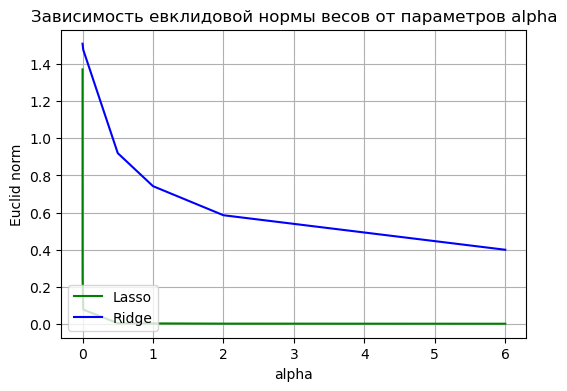

In [183]:
x = alphas
fid, ax = plt.subplots(figsize = (6, 4))

y1 = lasso_euclid
y2 = ridge_euclid

ax.plot(x, y1, color = 'green', label = 'Lasso')
ax.plot(x, y2, color = 'blue', label = 'Ridge')

ax.grid(True)
plt.xlabel('alpha')
plt.ylabel('Euclid norm')
plt.title('Зависимость евклидовой нормы весов от параметров alpha')

leg = ax.legend(loc = 'lower left', frameon = True)

Следовательно, Лассо агрессивней уменьшает веса

In [184]:
reg = LassoCV(cv = 5, alphas = [0.00001, 0.0001, 0.0003, 0.0005, 0.001, 0.01, 0.5, 1, 2, 6], random_state = 0).fit(X_train, y_train)
best_lasso = reg.alpha_
print('Лучший параметр альфа для Lasso: ', best_lasso)

Лучший параметр альфа для Lasso:  0.0005


In [185]:
lasso_cv = linear_model.Lasso(alpha = best_lasso)
lasso_cv.fit(X_train, y_train)
print('lasso cv MSE train: ', mean_squared_error(math.e**(y_train)-1, math.e**(lasso_cv.predict(X_train))-1))
print('lasso cv MSE test: ', mean_squared_error(math.e**(y_test)-1, math.e**(lasso_cv.predict(X_test))-1))
print('lasso cv MAE train: ', mean_absolute_error(math.e**(y_train)-1, math.e**(lasso_cv.predict(X_train))-1))
print('lasso cv MAE test: ', mean_absolute_error(math.e**(y_test)-1, math.e**(lasso_cv.predict(X_test))-1))
print('lasso cv r2_score train: ',r2_score(math.e**(y_train)-1, math.e**(lasso_cv.predict(X_train))-1))
print('lasso cv r2_score test: ', r2_score(math.e**(y_test)-1, math.e**(lasso_cv.predict(X_test))-1))

lasso cv MSE train:  325644217.7966059
lasso cv MSE test:  20633769772.43378
lasso cv MAE train:  12606.066609703525
lasso cv MAE test:  25033.51240322065
lasso cv r2_score train:  0.9474487639062195
lasso cv r2_score test:  -2.116330384197369


In [186]:
coef_lasso_cv = pd.DataFrame(lasso_cv.coef_, index = X.columns, columns = ['coef_lasso']).sort_values(by=['coef_lasso'])

In [192]:
coef_lasso_cv

,coef_lasso
Neighborhood_MeadowV,-0.042328
BsmtQual_Gd,-0.032917
BldgType_Twnhs,-0.030984
KitchenQual_Fa,-0.029979
HouseStyle_1Story,-0.029511
...,...
Functional_Typ,0.067592
SaleCondition_Normal,0.077641
Neighborhood_StoneBr,0.081319
SaleType_New,0.113496


In [188]:
reg = RidgeCV(cv = 5, alphas = [1, 2, 5, 10, 20, 30]).fit(X_train, y_train)
best_ridge = reg.alpha_
print('Лучший параметр альфа для Ridge: ', best_ridge)

Лучший параметр альфа для Ridge:  10


In [189]:
ridge_cv = linear_model.Ridge(alpha = best_ridge)
ridge_cv.fit(X_train, y_train)
print('ridge cv MSE train: ', mean_squared_error(math.e**(y_train)-1, math.e**(ridge_cv.predict(X_train))-1))
print('ridge cv MSE test: ', mean_squared_error(math.e**(y_test)-1, math.e**(ridge_cv.predict(X_test))-1))
print('ridge cv MAE train: ', mean_absolute_error(math.e**(y_train)-1, math.e**(ridge_cv.predict(X_train))-1))
print('ridge cv MAE test: ', mean_absolute_error(math.e**(y_test)-1, math.e**(ridge_cv.predict(X_test))-1))
print('ridge cv r2_score train: ',r2_score(math.e**(y_train)-1, math.e**(ridge_cv.predict(X_train))-1))
print('ridge cv r2_score test: ', r2_score(math.e**(y_test)-1, math.e**(ridge_cv.predict(X_test))-1))

ridge cv MSE train:  305278001.8165125
ridge cv MSE test:  18667254719.70788
ridge cv MAE train:  12122.08797473609
ridge cv MAE test:  24713.86564191299
ridge cv r2_score train:  0.9507353870544779
ridge cv r2_score test:  -1.8193264592055098


In [190]:
coef_ridge_cv = pd.DataFrame(ridge_cv.coef_, index = X.columns, columns = ['coef_ridge']).sort_values(by=['coef_ridge'])

In [191]:
coef_ridge_cv

,coef_ridge
Neighborhood_MeadowV,-0.055848
LandSlope_Sev,-0.048264
KitchenQual_Fa,-0.041731
Functional_Maj2,-0.041665
BsmtQual_Gd,-0.039340
...,...
BsmtFullBath,0.065061
Neighborhood_StoneBr,0.066675
Functional_Typ,0.067390
SaleCondition_Normal,0.073516


Гистограммы значений весов для линейной регрессии, Lasso, Ridge

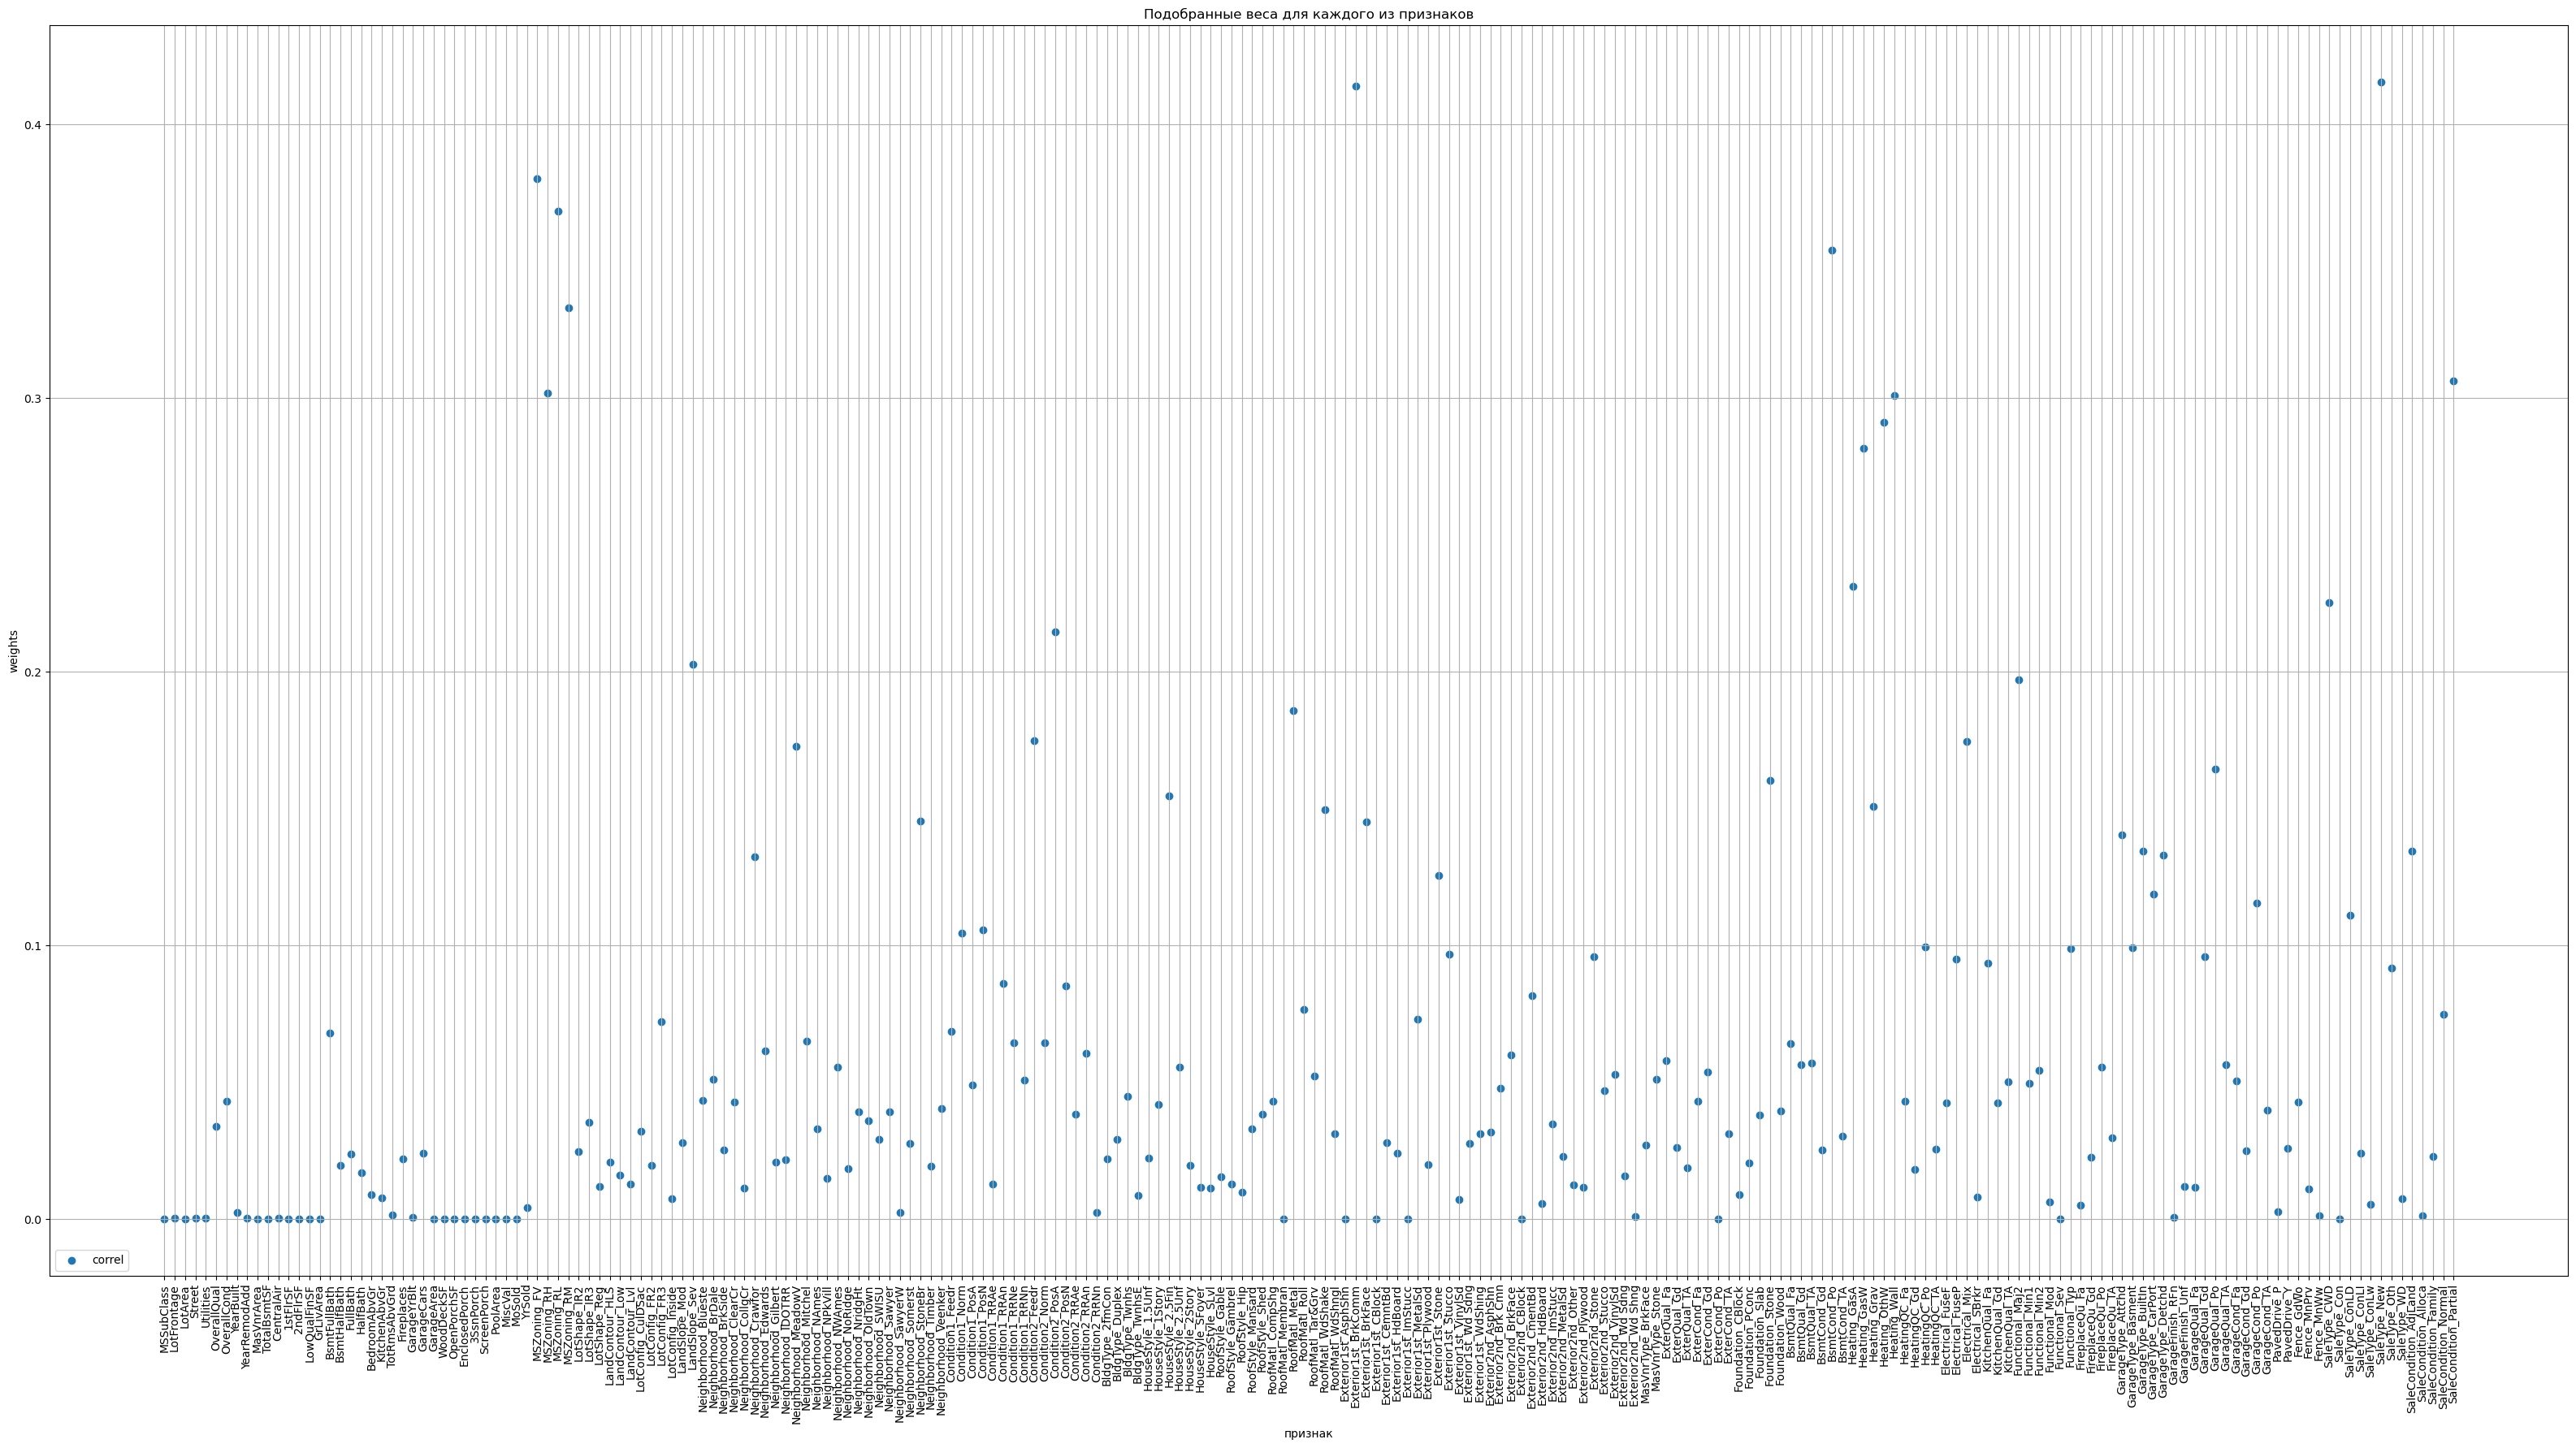

In [194]:
y1 = coef_lin_reg['coef'].abs()
fig, ax = plt.subplots(figsize = (40, 20))

x = X.columns

ax.scatter(x, y1, label = 'correl')
plt.xticks(rotation = 90)

ax.grid(True)
plt.xlabel('признак')
plt.ylabel('weights')
plt.title('Подобранные веса для каждого из признаков')

leg = ax.legend(loc = 'lower left', frameon = True)

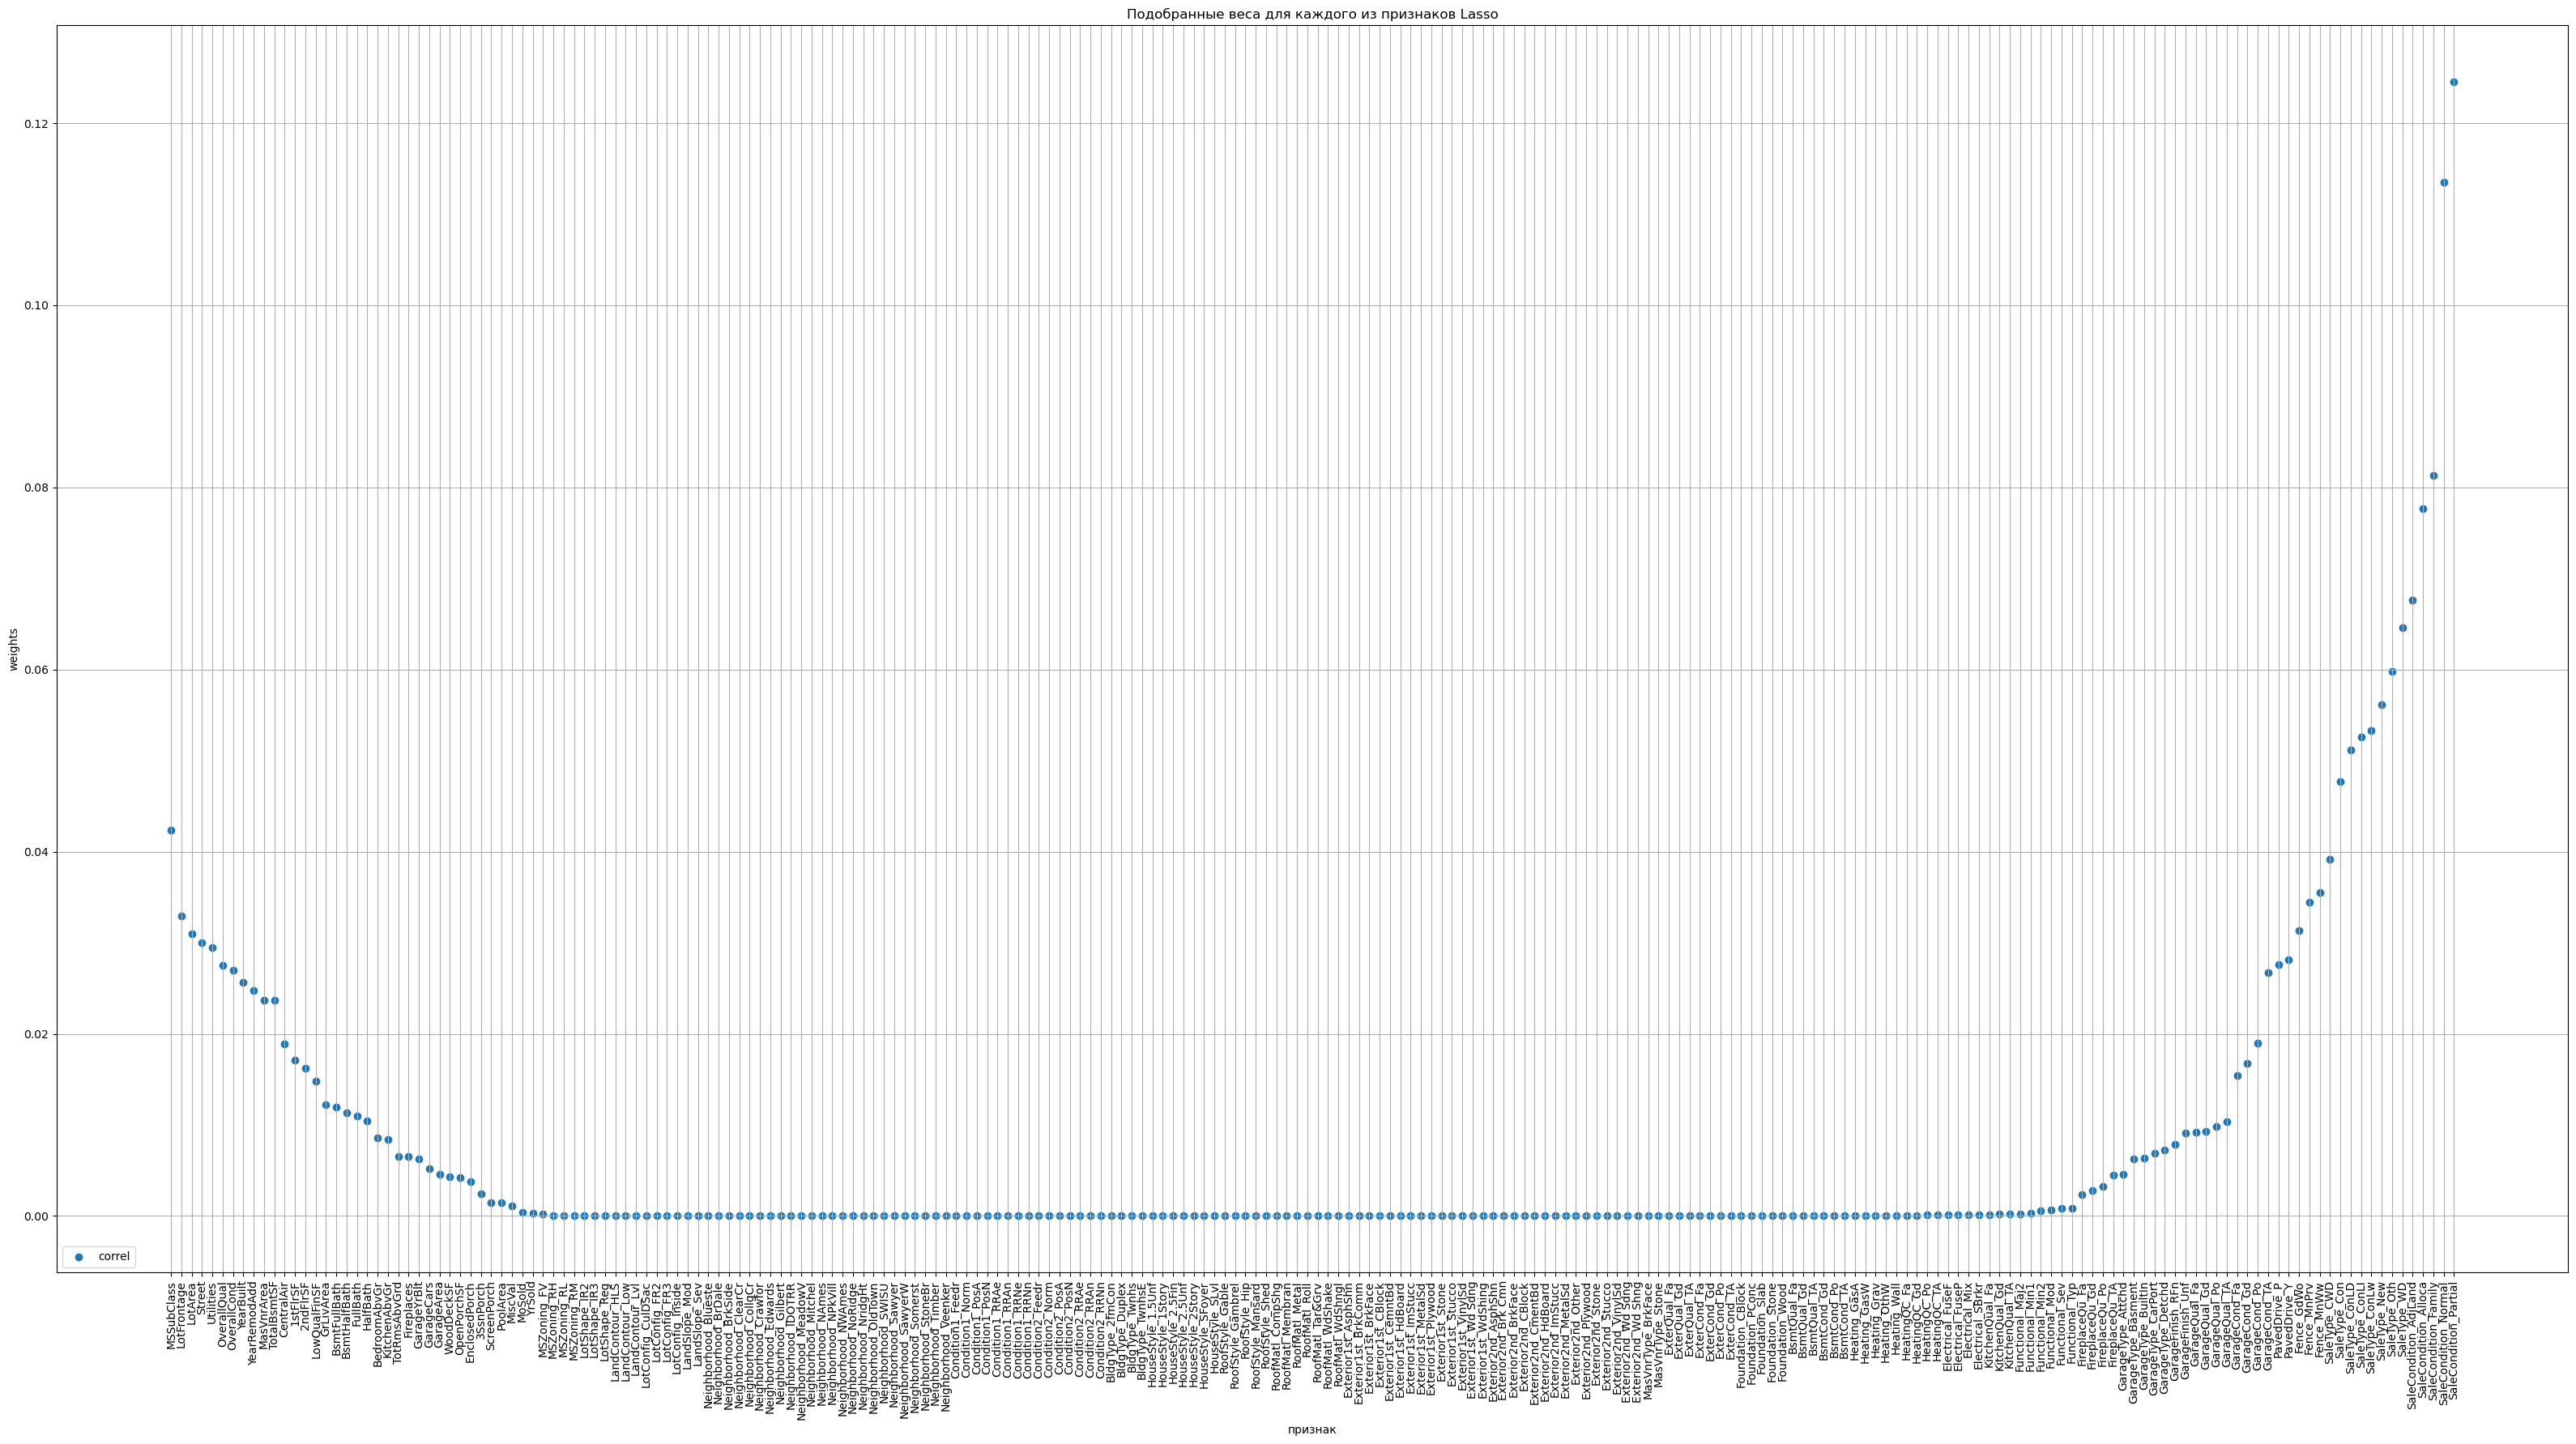

In [197]:
y1 = coef_lasso_cv['coef_lasso'].abs()
fig, ax = plt.subplots(figsize = (40, 20))

x = X.columns

ax.scatter(x, y1, label = 'correl')
plt.xticks(rotation = 90)

ax.grid(True)
plt.xlabel('признак')
plt.ylabel('weights')
plt.title('Подобранные веса для каждого из признаков Lasso')

leg = ax.legend(loc = 'lower left', frameon = True)

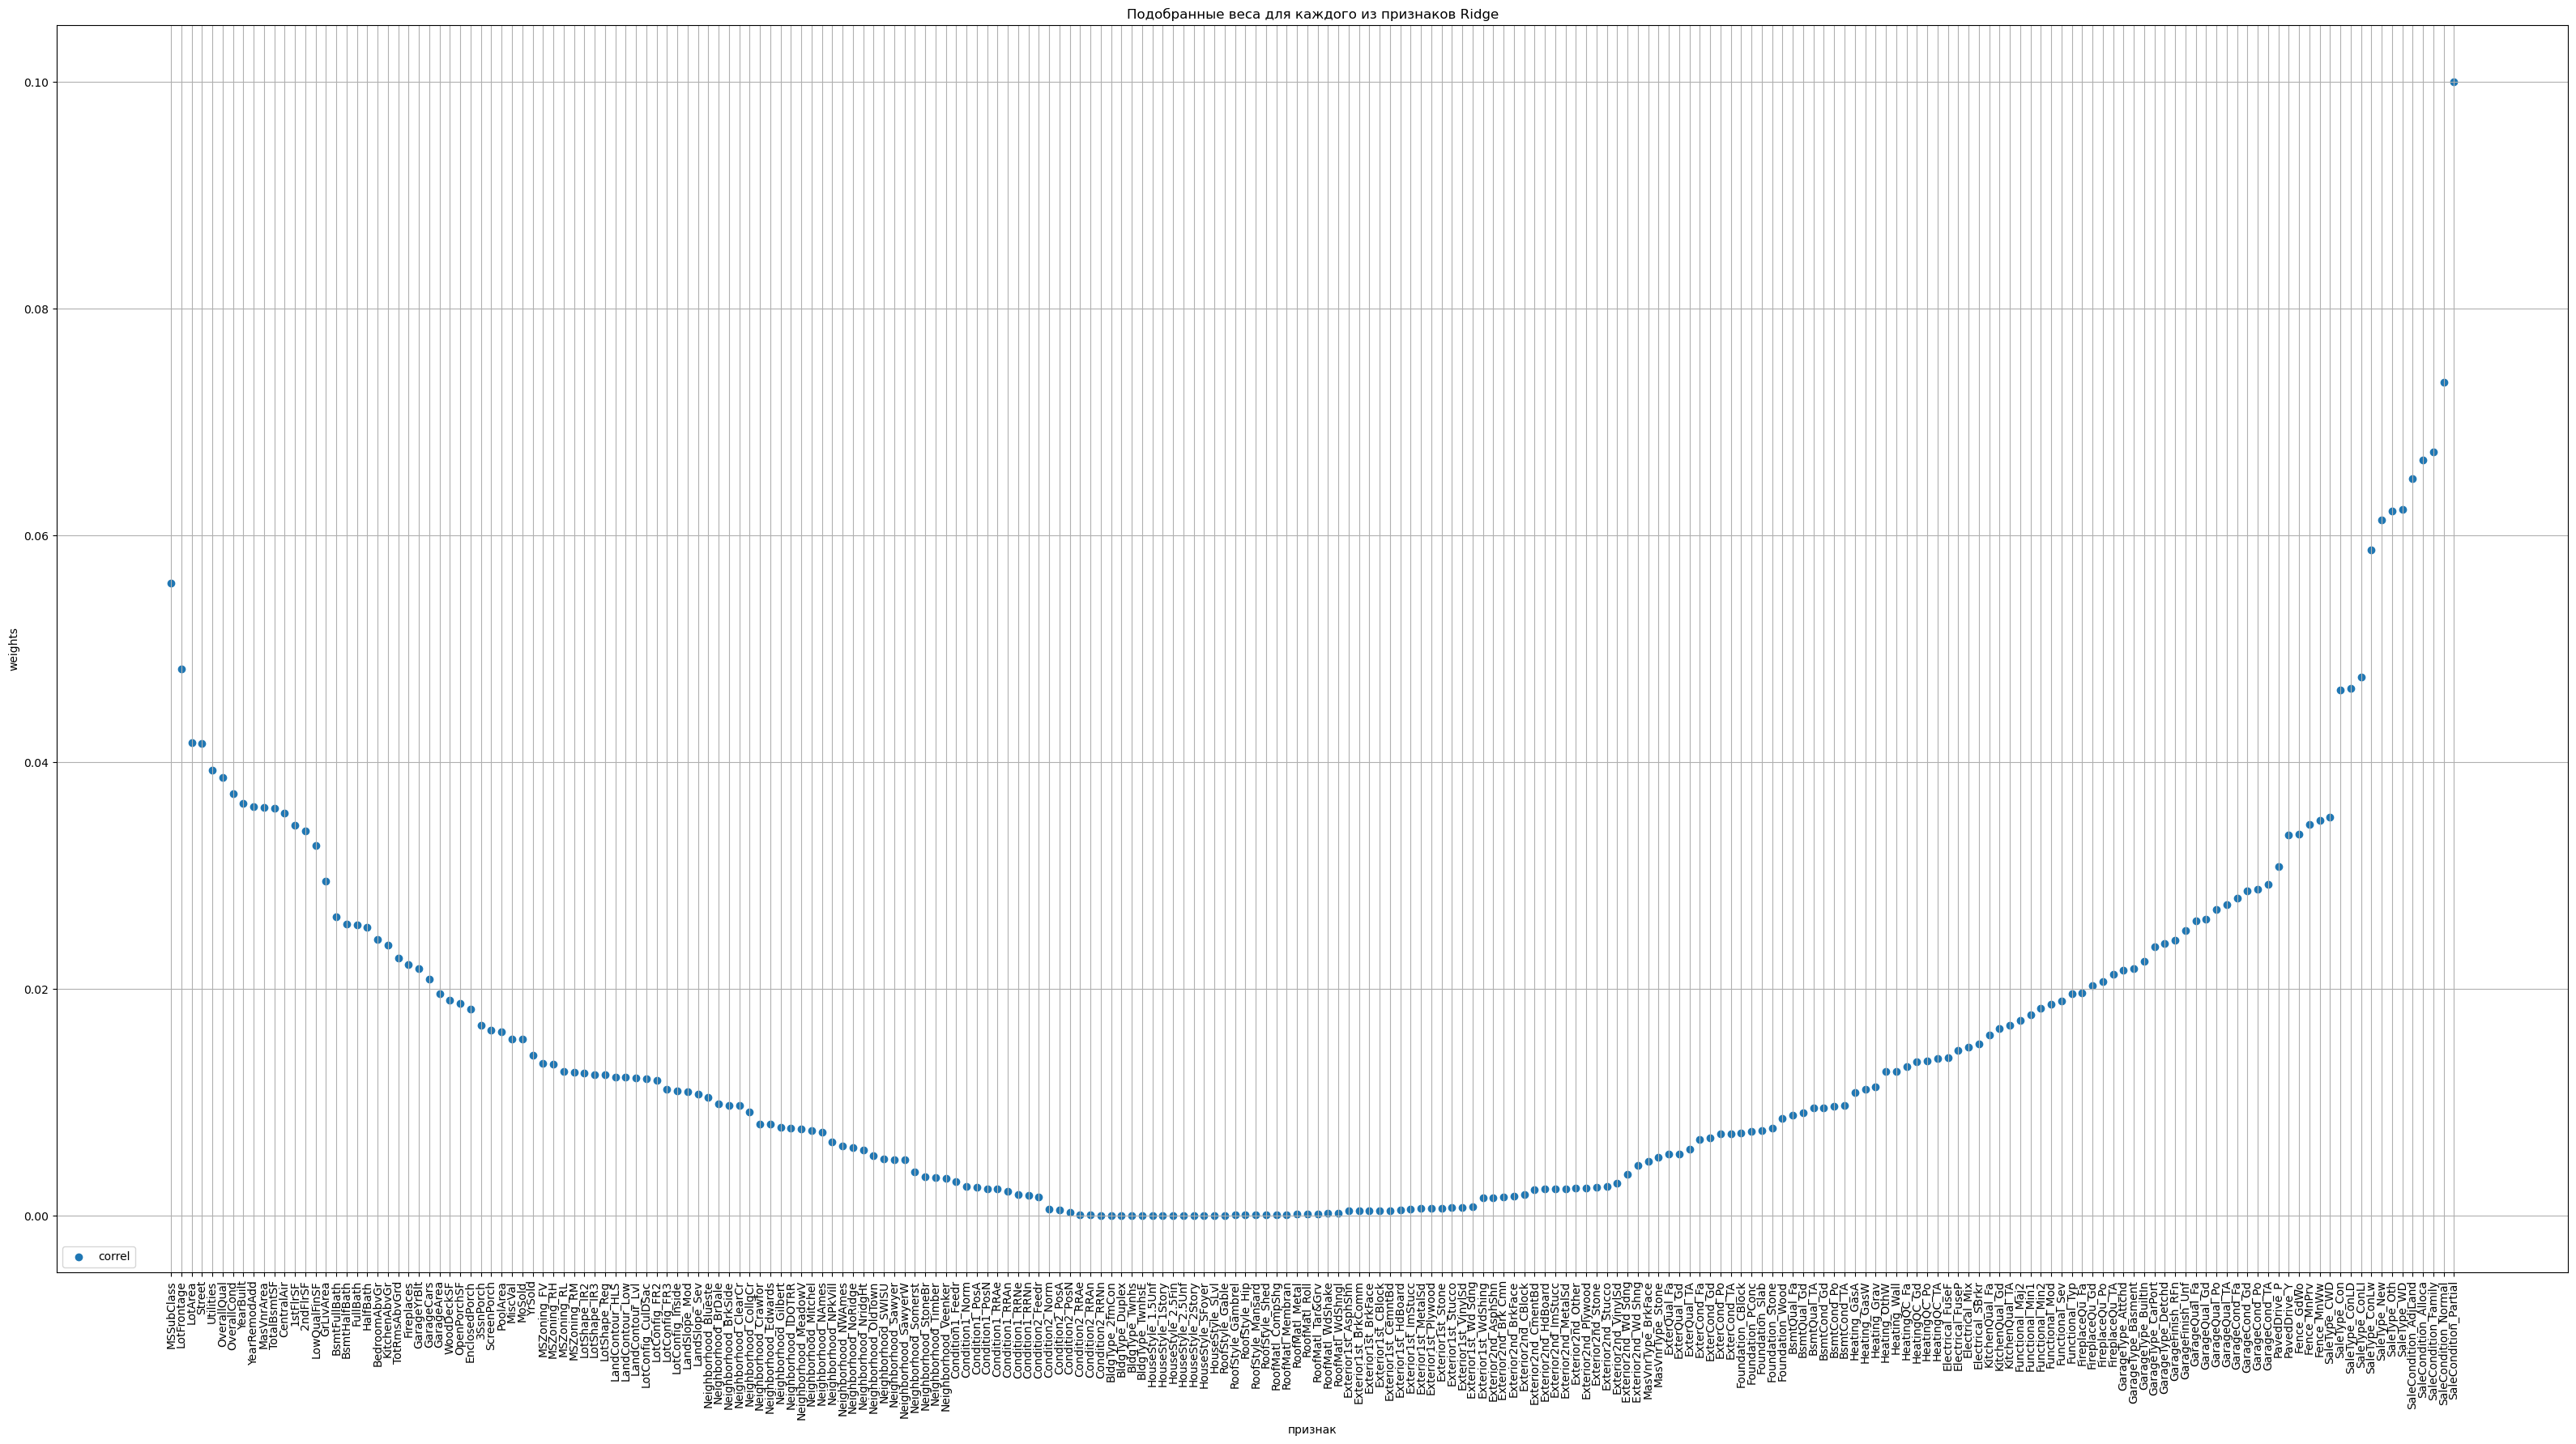

In [198]:
y1 = coef_ridge_cv['coef_ridge'].abs()
fig, ax = plt.subplots(figsize = (40, 20))

x = X.columns

ax.scatter(x, y1, label = 'correl')
plt.xticks(rotation = 90)

ax.grid(True)
plt.xlabel('признак')
plt.ylabel('weights')
plt.title('Подобранные веса для каждого из признаков Ridge')

leg = ax.legend(loc = 'lower left', frameon = True)

In [200]:
print('lin_reg MSE test: ', mean_squared_error(math.e**(y_test)-1, math.e**(lin_reg.predict(X_test))-1))
print('lasso cv MSE test: ', mean_squared_error(math.e**(y_test)-1, math.e**(lasso_cv.predict(X_test))-1))
print('ridge cv MSE test: ', mean_squared_error(math.e**(y_test)-1, math.e**(ridge_cv.predict(X_test))-1))

lin_reg MSE test:  16515884313.45381
lasso cv MSE test:  20633769772.43378
ridge cv MSE test:  18667254719.70788


На тестовой выборке меньшую ошибку по MSE дает при обычной Линейной регрессии

In [201]:
print('lin_reg MAE test: ', mean_absolute_error(math.e**(y_test)-1, math.e**(lin_reg.predict(X_test))-1))
print('lasso cv MAE test: ', mean_absolute_error(math.e**(y_test)-1, math.e**(lasso_cv.predict(X_test))-1))
print('ridge cv MAE test: ', mean_absolute_error(math.e**(y_test)-1, math.e**(ridge_cv.predict(X_test))-1))

lin_reg MAE test:  25147.443192018072
lasso cv MAE test:  25033.51240322065
ridge cv MAE test:  24713.86564191299


На тестовой выборке меньшую ошибку по MAE дает при Ridge

In [204]:
print('lin_reg r2_score test: ', r2_score(math.e**(y_test)-1, math.e**(lin_reg.predict(X_test))-1))
print('lasso cv r2_score test: ', r2_score(math.e**(y_test)-1, math.e**(lasso_cv.predict(X_test))-1))
print('ridge cv r2_score test: ', r2_score(math.e**(y_test)-1, math.e**(ridge_cv.predict(X_test))-1))

lin_reg r2_score test:  -1.4944037214501682
lasso cv r2_score test:  -2.116330384197369
ridge cv r2_score test:  -1.8193264592055098


На тестовой выборке наименьшую ошибку по r2_score дает при обычной Линейной регрессии